Epoch 1/10  Train Loss: 56478.7159  Test Loss: 49048.1005
Epoch 2/10  Train Loss: 47748.7939  Test Loss: 46332.6060
Epoch 3/10  Train Loss: 45816.8137  Test Loss: 45391.2454
Epoch 4/10  Train Loss: 45260.2145  Test Loss: 45015.9809
Epoch 5/10  Train Loss: 44830.0307  Test Loss: 44512.5550
Epoch 6/10  Train Loss: 44288.8736  Test Loss: 43897.5150
Epoch 7/10  Train Loss: 43672.6612  Test Loss: 43452.1959
Epoch 8/10  Train Loss: 43194.5303  Test Loss: 42960.5052
Epoch 9/10  Train Loss: 42877.2398  Test Loss: 42819.9988
Epoch 10/10  Train Loss: 42604.6153  Test Loss: 42582.8748


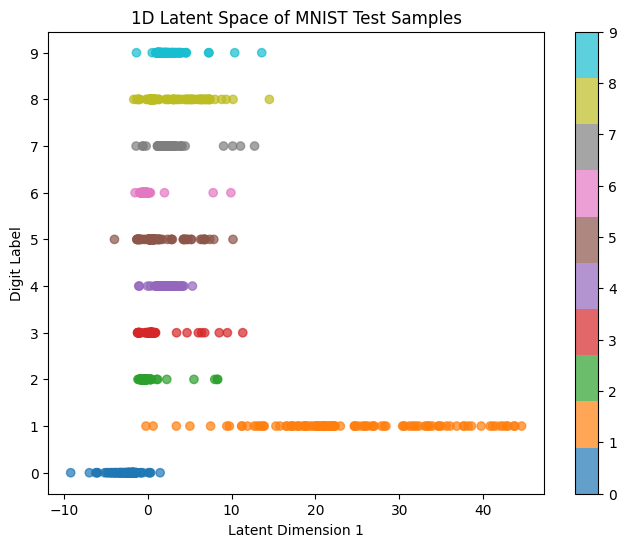

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse


class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=1):  # ← latent_dim default changed to 1
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


def train(model, loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for batch, _ in loader:
        batch = batch.view(batch.size(0), -1).to(device)
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    return train_loss / len(loader.dataset)


def test(model, loader, criterion, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, _ in loader:
            batch = batch.view(batch.size(0), -1).to(device)
            recon = model(batch)
            loss = criterion(recon, batch)
            test_loss += loss.item() * batch.size(0)
    return test_loss / len(loader.dataset)


def visualize_latent(model, loader, device, sample_size=1000, save_path='latent_space.png'):
    model.eval()
    # Collect all test images and labels
    all_images = []
    all_labels = []
    for batch, labels in loader:
        all_images.append(batch)
        all_labels.append(labels)
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Random sample
    idx = np.random.choice(len(all_images), sample_size, replace=False)
    sample_imgs = all_images[idx].view(sample_size, -1).to(device)
    sample_labels = all_labels[idx].cpu().numpy()

    with torch.no_grad():
        z = model.encoder(sample_imgs).cpu().numpy()  # shape (sample_size, 1)

    plt.figure(figsize=(8, 6))
    # 1D latent: plot latent value vs. true label
    sc = plt.scatter(z[:, 0], sample_labels, c=sample_labels, cmap='tab10', alpha=0.7)
    plt.colorbar(sc, ticks=range(10))
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Digit Label')
    plt.yticks(range(10))
    plt.title('1D Latent Space of MNIST Test Samples')
    plt.savefig(save_path, dpi=150)
    plt.show()


def main():
    parser = argparse.ArgumentParser(description='MNIST Autoencoder in PyTorch')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=256)
    parser.add_argument('--latent_dim', type=int, default=1)  # ← changed to 1
    parser.add_argument('--sample_size', type=int, default=1000)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--no_cuda', action='store_true')
    parser.add_argument('--output_dir', type=str, default='outputs')
    # Use parse_known_args to ignore Jupyter arguments
    args, unknown = parser.parse_known_args()

    device = "mps"
    os.makedirs(args.output_dir, exist_ok=True)

    # Data loaders
    transform = transforms.ToTensor()
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    input_dim = 28 * 28
    model = Autoencoder(input_dim, args.latent_dim).to(device)
    criterion = nn.BCELoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    for epoch in range(1, args.epochs + 1):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss = test(model, test_loader, criterion, device)
        print(f'Epoch {epoch}/{args.epochs}  Train Loss: {train_loss:.4f}  Test Loss: {test_loss:.4f}')

    # Save model
    torch.save(model.state_dict(), os.path.join(args.output_dir, 'autoencoder.pth'))

    # Visualize latent space
    visualize_latent(model, test_loader, device, sample_size=args.sample_size,
                     save_path=os.path.join(args.output_dir, 'latent_space.png'))

if __name__ == '__main__':
    main()

In [18]:
import ipywidgets as widgets
from ipywidgets import interactive

model = Autoencoder(input_dim=784, latent_dim=1).to("mps")
model.load_state_dict(torch.load('outputs/autoencoder.pth', map_location='mps'))


def show_reconstructed(z1):
    z = torch.tensor([z1], dtype=torch.float32).to("mps")
    with torch.no_grad():
        reconstructed = model.decoder(z.unsqueeze(0)).cpu().numpy()
    reconstructed_image = reconstructed.reshape(28, 28)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'Reconstructed Image\nz=[{z1:.2f}]')
    plt.axis('off')
    plt.show()

interactive_plot = interactive(
    show_reconstructed,
    z1=widgets.FloatSlider(min=-20, max=30, step=0.05, value=0.1, description='z1'),
    # z2=widgets.FloatSlider(min=-20, max=30, step=0.05, value=0.1, description='z2')
)
display(interactive_plot)


interactive(children=(FloatSlider(value=0.1, description='z1', max=30.0, min=-20.0, step=0.05), Output()), _do…